In [1]:
import pandas as pd
import numpy as np

from collections import Counter

from haversine import haversine # too slow
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from catboost import CatBoostRegressor
from catboost import cv
from catboost import Pool

pd.set_option('display.max_columns', None)


## 1. Загрузка данных

In [2]:
ls ../../data

test_additional.csv      test.csv.zip   train.csv.zip   validation.csv.zip
test_additional.csv.zip  test_ext2.csv  train_ext2.csv  valid_ext2.csv
test.csv                 train.csv      validation.csv


In [3]:
train_df = pd.read_csv("../../data/train.csv")

In [4]:
test_df = pd.read_csv("../../data/test.csv")

In [32]:
test_additional_df = pd.read_csv("../../data/test_additional.csv")

In [35]:
test_additional_df.head()

,Id,main_id_locality,ETA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,ReadyForCollection,ClientCollected,ready_latitude,ready_longitude,onway_latitude,onway_longitude,arrived_latitude,arrived_longitude,center_latitude,center_longitude,route
0,0,1078,1212,2020-03-28 00:00:05,55.751270,55.836491,49.183281,49.140308,13,2020-03-28 00:05:57,2020-03-28 00:07:01,55.751545,49.183875,55.751545,49.183875,55.836686,49.139695,55.794388,49.111531,o|gsIibekHlBG??R~U??{@E}EH??@zC`@zNP|AP`A^vARn...
1,1,1078,968,2020-03-28 00:00:29,55.829720,55.819080,49.116032,49.183521,8,2020-03-28 00:05:02,2020-03-28 00:06:25,55.829027,49.117553,55.828543,49.115434,55.819152,49.183329,55.794388,49.111531,ofwsIy~wjHzBhF|@Av@gBb@iAFG??tA???H@lAEj@r@??A...
2,2,1078,492,2020-03-28 00:00:31,55.785660,55.783699,49.173920,49.195599,3,2020-03-28 00:07:14,2020-03-28 00:07:25,55.786520,49.173341,55.786455,49.173383,55.783292,49.195962,55.794388,49.111531,qtnsIcickHKh@oAv@c@bC??q@i@??x@qGB}@fA}GHiA|@o...
3,3,1078,953,2020-03-28 00:00:42,55.792568,55.824730,49.172691,49.084911,9,2020-03-28 00:12:28,2020-03-28 00:12:32,55.792422,49.172795,55.792422,49.172795,55.824720,49.084409,55.794388,49.111531,q~osIi`ckHx@B??L???A~AW???ArB??gFYsAA??On@fAjP...
4,4,1078,1746,2020-03-28 00:00:47,55.829369,55.757278,49.092682,49.236542,16,2020-03-28 00:02:56,2020-03-28 00:04:20,55.829351,49.093344,55.829648,49.093254,55.757308,49.236968,55.794388,49.111531,qdwsIilsjHcA^iCjAk@|@??S}DoA_QSuCC_A?kEHgS??`I...


In [34]:
test_df.shape

(89938, 11)

In [5]:
# 45.040235	38.976080 Краснодар
# 54.734853	55.957865 Уфа
# 53.516670	49.416670 Тольятти
# 56.838633	60.605489 Екатеринбург

In [6]:
train_df.head()

,Id,main_id_locality,ETA,RTA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,RDA,ReadyForCollection,ClientCollected,GoodArrived,ready_latitude,ready_longitude,onway_latitude,onway_longitude,arrived_latitude,arrived_longitude,center_latitude,center_longitude,route,track
0,0,1078,226.0,188.0,2020-02-12 19:12:06,55.826019,55.825581,49.134529,49.126949,1.0,1.0,2020-02-12 19:14:33,2020-02-12 19:15:06,2020-02-12 19:18:14,55.825647,49.134115,55.826261,49.134137,55.825707,49.127136,55.794388,49.111531,gnvsIaq{jHChA??uC???OPG^F^NRzKBd@AN[r@???`@`@`...,io{jHkivsID_A??A}@i@m@I]^SFKBK@AD@@????A?@??A@...
1,1,1078,718.0,725.0,2020-02-12 19:12:22,55.795502,55.820911,49.131470,49.115360,5.0,6.0,2020-02-12 19:19:03,2020-02-12 19:19:42,2020-02-12 19:31:47,55.795591,49.132281,55.795544,49.131552,55.821531,49.115685,55.794388,49.111531,sqpsI}~zjHyAr]e@lMk@fLaBlb@i@rLKhBCdAUxEGlCg@f...,qh{jHappsIAAA?\EVSLAC@r@I????h@ERAL?R?x@Cf@ARD...
2,2,1078,612.0,764.0,2020-02-12 19:12:44,55.791050,55.819962,49.226070,49.176628,5.0,5.0,2020-02-12 19:15:21,2020-02-12 19:15:25,2020-02-12 19:28:09,55.791099,49.226066,55.791099,49.226066,55.819765,49.177432,55.794388,49.111531,auosI}mmkH?LHd@KhC??o@w@[g@m@iAUk@??{G|OiB`Ek@...,}mmkHkuosI????????????????????????????????K?O@...
3,3,1078,1560.0,1412.0,2020-02-12 19:12:44,55.753899,55.824680,49.188519,49.093700,13.0,14.0,2020-02-12 19:19:00,2020-02-12 19:19:09,2020-02-12 19:42:41,55.754116,49.188853,55.754116,49.188853,55.824734,49.094013,55.794388,49.111531,{lhsIiffkHmKN_C?mIPwMJ??Si@gA{B??Wq@MRCJTp@hAd...,gefkH{{hsIQr@Gn@GlAAr@Ct@@^@J@ZFf@FVHHDD??????...
4,4,1078,1528.0,893.0,2020-02-12 19:12:45,55.822361,55.786758,49.069092,49.143501,9.0,10.0,2020-02-12 19:16:32,2020-02-12 19:17:26,2020-02-12 19:32:19,55.822483,49.069659,55.822617,49.069229,55.786936,49.143330,55.794388,49.111531,yxusI{xnjHgAfG??}IuHkAqA??pIoe@VsA??dAkG`BuH??...,synjHkzusIHAA?E@C?????????????????????????DARE...


In [7]:
train_df["main_id_locality"].value_counts()

1078     313636
22438    202833
22390    184584
22430    136075
Name: main_id_locality, dtype: int64

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837128 entries, 0 to 837127
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  837128 non-null  int64  
 1   main_id_locality    837128 non-null  int64  
 2   ETA                 837128 non-null  float64
 3   RTA                 837128 non-null  float64
 4   OrderedDate         837128 non-null  object 
 5   latitude            837128 non-null  float64
 6   del_latitude        837128 non-null  float64
 7   longitude           837128 non-null  float64
 8   del_longitude       837128 non-null  float64
 9   EDA                 837128 non-null  float64
 10  RDA                 837128 non-null  float64
 11  ReadyForCollection  837128 non-null  object 
 12  ClientCollected     837128 non-null  object 
 13  GoodArrived         837128 non-null  object 
 14  ready_latitude      834220 non-null  float64
 15  ready_longitude     834220 non-nul

In [9]:
mean = (train_df["ETA"] - train_df["RTA"]).mean()
mean

162.22325498609533

In [10]:
koeff = (train_df["RTA"].sum() + train_df["RTA"].shape[0]) / train_df["ETA"].sum()
koeff

0.8254837356201216

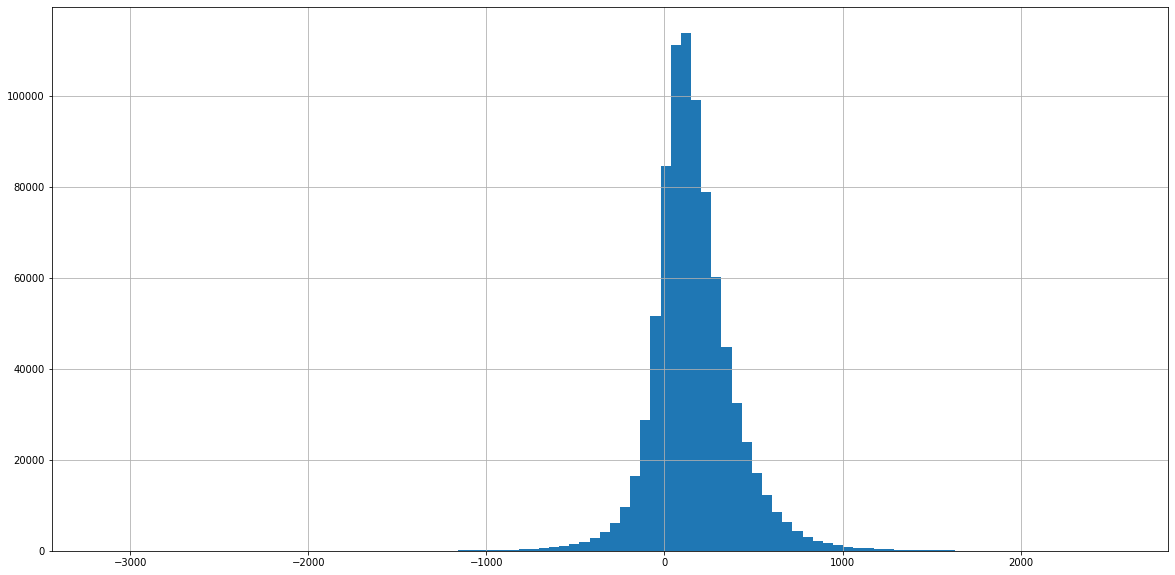

In [11]:
(train_df["ETA"] - train_df["RTA"]).hist(figsize=(20,10), bins=100)

Ожидаемое время выше реального (измерение в секундах)

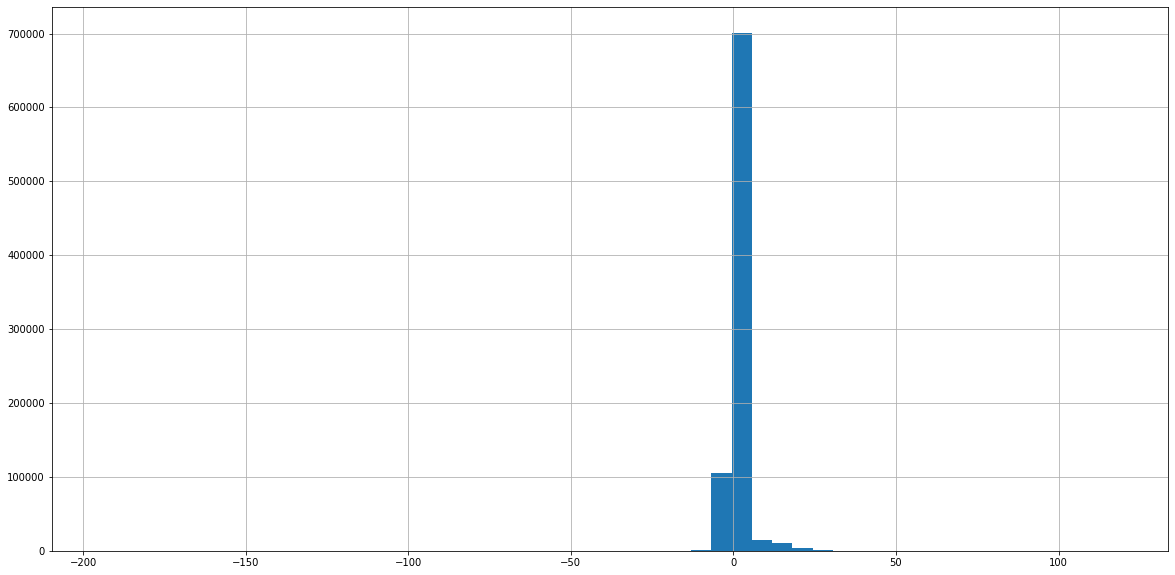

In [13]:
(train_df["EDA"] - train_df["RDA"]).hist(figsize=(20,10), bins=50)

In [14]:
import polyline
polyline.decode(train_df.loc[0, 'route'])[:5]

[(55.8258, 49.13441),
 (55.82582, 49.13404),
 (55.82582, 49.13404),
 (55.82657, 49.13404),
 (55.82657, 49.13404)]

## 3. Анализ маршрутов

In [15]:
import geopy.distance
from tqdm import tqdm_notebook
from haversine import haversine

In [16]:
train_df["route"].dropna().shape[0], train_df["route"].shape[0]

(821253, 837128)

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89938 entries, 0 to 89937
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                89938 non-null  int64  
 1   main_id_locality  89938 non-null  int64  
 2   ETA               89938 non-null  float64
 3   OrderedDate       89938 non-null  object 
 4   latitude          89938 non-null  float64
 5   del_latitude      89938 non-null  float64
 6   longitude         89938 non-null  float64
 7   del_longitude     89938 non-null  float64
 8   EDA               89938 non-null  float64
 9   center_latitude   89938 non-null  float64
 10  center_longitude  89938 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 7.5+ MB


Маршрут:
1. Кол-во ребер
2. Средняя длина ребер
3. Сумма длин ребер 
4. Сумма удаленностей от центра каждой точки пути
5. Средняя удаленность от центра
6. Сумма углов между ребрами пути
7. Средний угол 
8. Кол-во кластеров в маршруте
9. Принадлежность к кластеру (one-hot)

Начальна и конечная точки
1. Геогрфическое расстояние от начальной до конечной точки
2. Коэффициент перепробега (отношение реальной длины к расстоянию между точками)
3. Удаленность от центра города начала маршрута
4. Удаленнность от центра города конца маршрута

Город:
1. Средняя длина маршрутов
2. Среднее кол-во ребер 
3. Среднее расстояние между точками начало и конец
4. Средний коэффициент перепробега
5. Средняя сумма удаленностей от центра
6. Средний угол
7. Средняя сумма углов между ребрами пути



Отрисовка на карте маршрута

In [18]:
coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(geopy.distance.distance(coords_1, coords_2).km)

279.35290160430094


In [19]:
train_df.columns

Index(['Id', 'main_id_locality', 'ETA', 'RTA', 'OrderedDate', 'latitude',
       'del_latitude', 'longitude', 'del_longitude', 'EDA', 'RDA',
       'ReadyForCollection', 'ClientCollected', 'GoodArrived',
       'ready_latitude', 'ready_longitude', 'onway_latitude',
       'onway_longitude', 'arrived_latitude', 'arrived_longitude',
       'center_latitude', 'center_longitude', 'route', 'track'],
      dtype='object')

In [26]:
# Геогрфическое расстояние от начальной до конечной точки
train_df['haversine'] = train_df.apply(lambda row: haversine((row['latitude'], row['longitude']), 
                             (row['del_latitude'], row['del_longitude'])), axis=1)

In [27]:
# Удаленность от центра города начала маршрута
train_df['start_offset'] = train_df.apply(lambda row: haversine((row['latitude'], row['longitude']), 
                             (row['center_latitude'], row['center_longitude'])), axis=1)

In [28]:
# Удаленность от центра города конца маршрута
train_df['finish_offset'] = train_df.apply(lambda row: haversine((row['del_latitude'], row['del_longitude']), 
                             (row['center_latitude'], row['center_longitude'])), axis=1)

In [29]:
# Коэффициент перепробега (отношение реальной длины к расстоянию между точками)
train_df["koeff_overroute"] = train_df.apply(lambda row: row['EDA'] / row['haversine'], axis=1)

In [31]:
test_df.head()

,Id,main_id_locality,ETA,OrderedDate,latitude,del_latitude,longitude,del_longitude,EDA,center_latitude,center_longitude
0,0,1078,1212.0,2020-03-28 00:00:05,55.751270,55.836491,49.183281,49.140308,13.0,55.794388,49.111531
1,1,1078,968.0,2020-03-28 00:00:29,55.829720,55.819080,49.116032,49.183521,8.0,55.794388,49.111531
2,2,1078,492.0,2020-03-28 00:00:31,55.785660,55.783699,49.173920,49.195599,3.0,55.794388,49.111531
3,3,1078,953.0,2020-03-28 00:00:42,55.792568,55.824730,49.172691,49.084911,9.0,55.794388,49.111531
4,4,1078,1746.0,2020-03-28 00:00:47,55.829369,55.757278,49.092682,49.236542,16.0,55.794388,49.111531


In [ ]:
# %%timeit
# haversine(coords_1, coords_2)

In [ ]:
# %%timeit
# get_distance(coords_1, coords_2)

In [20]:
def get_route_features(row):
    features = {}
    parts = polyline.decode(row["route"])
    
    parts_count = len(parts)
    parts_distance_sum = 0
    
    for i in range(0, len(parts) - 1):
        parts_distance_sum += get_distance(parts[i], parts[i + 1])

    features["parts_count"] = parts_count
    features["parts_distance_sum"] = parts_distance_sum
    features["parts_distance_avg"] = parts_distance_sum / parts_count
    
    return features

In [21]:
def get_route_features(row):
    features = {}
   
    try:        
        parts = polyline.decode(row["route"])

        parts_count = len(parts)
        parts_distance_sum = 0

        for i in range(0, len(parts) - 1):
            parts_distance_sum += haversine(parts[i], parts[i + 1])

        features["parts_count"] = parts_count
        features["parts_distance_sum"] = parts_distance_sum
        features["parts_distance_avg"] = parts_distance_sum / parts_count
    except:
        features["parts_count"] = 0
        features["parts_distance_sum"] = 0
        features["parts_distance_avg"] = 0

    return features

In [ ]:
train_route_features = []
for idx, row in tqdm_notebook(train_df.iterrows()):
    train_route_features.append(get_route_features(row))

In [ ]:
train_route_features[0]

In [ ]:
train_route_features_df = pd.DataFrame(train_route_features)

In [ ]:
train_route_features_df.shape

In [ ]:
train_route_features_df.head()

In [ ]:
train_df.shape

In [ ]:
train_df.head()

In [ ]:
train_routes_df = pd.concat([train_df, train_route_features_df], axis=1)

In [ ]:
train_routes_df.shape

## 4. Code

In [22]:
train_df = pd.read_csv("../../data/train.csv")

In [23]:
valid_df = pd.read_csv("../../data/validation.csv")

In [24]:
test_df = pd.read_csv("../../data/test.csv")

In [36]:
test_additional_df = pd.read_csv("../../data/test_additional.csv")

In [37]:
test_df["route"] = test_additional_df["route"]

In [38]:
def get_new_features(train_df):
    # Геогрфическое расстояние от начальной до конечной точки
    train_df.loc[:, 'haversine'] = train_df.apply(lambda row: haversine((row['latitude'], row['longitude']), 
                             (row['del_latitude'], row['del_longitude'])), axis=1)
    
    # Удаленность от центра города начала маршрута
    train_df.loc[:, 'start_offset'] = train_df.apply(lambda row: haversine((row['latitude'], row['longitude']), 
                             (row['center_latitude'], row['center_longitude'])), axis=1)

    
    # Удаленность от центра города конца маршрута
    train_df.loc[:, 'finish_offset'] = train_df.apply(lambda row: haversine((row['del_latitude'], row['del_longitude']), 
                             (row['center_latitude'], row['center_longitude'])), axis=1)
    
    # Коэффициент перепробега (отношение реальной длины к расстоянию между точками)
    train_df.loc[:, "koeff_overroute"] = train_df.apply(lambda row: row['EDA'] / row['haversine'], axis=1)
    
    
    train_route_features = []
    for idx, row in tqdm_notebook(train_df.iterrows()):
        train_route_features.append(get_route_features(row))
        
    
    train_route_features_df = pd.DataFrame(train_route_features)
    
    train_routes_df = pd.concat([train_df, train_route_features_df], axis=1)
    
    
    feature_names = ["start_offset", "finish_offset", "koeff_overroute", "parts_count", 
                     "parts_distance_sum", "parts_distance_avg"]
    
    new_features_df = train_routes_df[feature_names]
    
    return new_features_df

In [39]:
train_df_extended = get_new_features(train_df)

/media/xsardas/NVME/Citymobil/venv_city/lib/python3.6/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [40]:
train_df_extended.head()

,start_offset,finish_offset,koeff_overroute,parts_count,parts_distance_sum,parts_distance_avg
0,3.799506,3.599806,2.101118,29,1.092983,0.037689
1,1.252478,2.958996,1.667000,78,4.924570,0.063136
2,7.169754,4.963273,1.121356,79,5.139108,0.065052
3,6.591937,3.547877,1.319370,164,12.724734,0.077590
4,4.087530,2.171232,1.473710,130,9.052948,0.069638


In [41]:
valid_df_extended = get_new_features(valid_df)

/media/xsardas/NVME/Citymobil/venv_city/lib/python3.6/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [42]:
test_df_extended = get_new_features(test_df)

/media/xsardas/NVME/Citymobil/venv_city/lib/python3.6/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [43]:
test_df_extended.head()

,start_offset,finish_offset,koeff_overroute,parts_count,parts_distance_sum,parts_distance_avg
0,6.566948,5.014991,1.319868,173,12.839233,0.074215
1,3.938777,5.270377,1.827163,90,7.466408,0.082960
2,4.019264,5.388477,2.185143,53,2.468043,0.046567
3,3.828554,3.761648,1.374473,127,8.486010,0.066819
4,4.064094,8.840243,1.328134,152,16.215731,0.106682


In [44]:
!ls  ../../data

test_additional.csv	 test.csv.zip	train.csv.zip	validation.csv.zip
test_additional.csv.zip  test_ext2.csv	train_ext2.csv	valid_ext2.csv
test.csv		 train.csv	validation.csv


In [45]:
train_df_extended.to_csv("../../data/train_extended.csv", index=False)

In [46]:
valid_df_extended.to_csv("../../data/valid_extended.csv", index=False)

In [47]:
test_df_extended.to_csv("../../data/test_extended.csv", index=False)

## 5. Train

In [62]:
train_ext2 = pd.read_csv("../../data/train_ext2.csv")
valid_ext2 = pd.read_csv("../../data/valid_ext2.csv")
test_ext2 = pd.read_csv("../../data/test_ext2.csv")

In [59]:
train_ext2.head()

,Id,main_id_locality,ETA,pickup_latitude,dropoff_latitude,pickup_longitude,dropoff_longitude,EDA,center_latitude,center_longitude,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,distance_haversine,distance_dummy_manhattan,direction,pca_manhattan,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,pickup_cluster,dropoff_cluster,avg_speed_h_gby_pickup_hour,avg_speed_m_gby_pickup_hour,log_trip_duration_gby_pickup_hour,avg_speed_h_gby_pickup_date,avg_speed_m_gby_pickup_date,log_trip_duration_gby_pickup_date,avg_speed_h_gby_pickup_dt_bin,avg_speed_m_gby_pickup_dt_bin,log_trip_duration_gby_pickup_dt_bin,avg_speed_h_gby_pickup_week_hour,avg_speed_m_gby_pickup_week_hour,log_trip_duration_gby_pickup_week_hour,avg_speed_h_gby_pickup_cluster,avg_speed_m_gby_pickup_cluster,log_trip_duration_gby_pickup_cluster,avg_speed_h_gby_dropoff_cluster,avg_speed_m_gby_dropoff_cluster,log_trip_duration_gby_dropoff_cluster
0,0,1078,226.0,55.826019,55.825581,49.134529,49.126949,1.0,55.825800,49.130739,-0.893777,-1.378632,-0.900514,-1.382132,0.475936,0.522207,-95.879608,0.010238,2,7,19,12,2056285.0,67,64,63,5.459265,6.999325,6.423005,5.215243,6.688212,6.513568,5.457045,6.982554,6.4522,5.401272,6.929604,6.441993,6.014004,7.581035,6.457459,5.661696,7.180574,6.447411
1,1,1078,718.0,55.795502,55.820911,49.131470,49.115360,5.0,55.808207,49.123415,-0.912015,-1.353974,-0.912861,-1.384048,2.999397,3.832401,-19.603279,0.030920,2,7,19,12,2056301.0,67,90,63,5.459265,6.999325,6.423005,5.215243,6.688212,6.513568,5.457045,6.982554,6.4522,5.401272,6.929604,6.441993,6.119228,7.870835,6.420048,5.661696,7.180574,6.447411
2,2,1078,612.0,55.791050,55.819962,49.226070,49.176628,5.0,55.805506,49.201349,-0.833002,-1.301762,-0.860700,-1.351894,4.458880,6.305716,-43.843021,0.077830,2,7,19,12,2056323.0,67,54,14,5.459265,6.999325,6.423005,5.215243,6.688212,6.513568,5.457045,6.982554,6.4522,5.401272,6.929604,6.441993,5.850607,7.499397,6.571342,6.065958,7.751825,6.616904
3,3,1078,1560.0,55.753899,55.824680,49.188519,49.093700,13.0,55.789289,49.141109,-0.884273,-1.289045,-0.929545,-1.398365,9.853176,13.803791,-36.946603,0.154593,2,7,19,12,2056323.0,67,67,4,5.459265,6.999325,6.423005,5.215243,6.688212,6.513568,5.457045,6.982554,6.4522,5.401272,6.929604,6.441993,5.423937,7.028498,6.538926,5.730565,7.348535,6.427492
4,4,1078,1528.0,55.822361,55.786758,49.069092,49.143501,9.0,55.804560,49.106297,-0.951878,-1.408959,-0.906148,-1.340307,6.107029,8.606808,130.378310,0.114382,2,7,19,12,2056324.0,67,93,7,5.459265,6.999325,6.423005,5.215243,6.688212,6.513568,5.457045,6.982554,6.4522,5.401272,6.929604,6.441993,5.530983,7.140986,6.550487,5.593248,7.150013,6.485789


In [60]:
drop_cols = ["pickup_weekday", "main_id_locality", "ETA", "Id", "pickup_weekday", "pickup_hour", 
            "pickup_minute"]

In [61]:
cat_features = ["pickup_hour_weekofyear", "pickup_week_hour", "pickup_cluster", "dropoff_cluster", "dropoff_cluster"]

In [63]:
train_ext2.drop(drop_cols, axis=1, inplace=True)

In [64]:
train_ext2.head()

,pickup_latitude,dropoff_latitude,pickup_longitude,dropoff_longitude,EDA,center_latitude,center_longitude,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,distance_haversine,distance_dummy_manhattan,direction,pca_manhattan,pickup_hour_weekofyear,pickup_hour,pickup_dt,pickup_week_hour,pickup_cluster,dropoff_cluster,avg_speed_h_gby_pickup_hour,avg_speed_m_gby_pickup_hour,log_trip_duration_gby_pickup_hour,avg_speed_h_gby_pickup_date,avg_speed_m_gby_pickup_date,log_trip_duration_gby_pickup_date,avg_speed_h_gby_pickup_dt_bin,avg_speed_m_gby_pickup_dt_bin,log_trip_duration_gby_pickup_dt_bin,avg_speed_h_gby_pickup_week_hour,avg_speed_m_gby_pickup_week_hour,log_trip_duration_gby_pickup_week_hour,avg_speed_h_gby_pickup_cluster,avg_speed_m_gby_pickup_cluster,log_trip_duration_gby_pickup_cluster,avg_speed_h_gby_dropoff_cluster,avg_speed_m_gby_dropoff_cluster,log_trip_duration_gby_dropoff_cluster
0,55.826019,55.825581,49.134529,49.126949,1.0,55.825800,49.130739,-0.893777,-1.378632,-0.900514,-1.382132,0.475936,0.522207,-95.879608,0.010238,7,19,2056285.0,67,64,63,5.459265,6.999325,6.423005,5.215243,6.688212,6.513568,5.457045,6.982554,6.4522,5.401272,6.929604,6.441993,6.014004,7.581035,6.457459,5.661696,7.180574,6.447411
1,55.795502,55.820911,49.131470,49.115360,5.0,55.808207,49.123415,-0.912015,-1.353974,-0.912861,-1.384048,2.999397,3.832401,-19.603279,0.030920,7,19,2056301.0,67,90,63,5.459265,6.999325,6.423005,5.215243,6.688212,6.513568,5.457045,6.982554,6.4522,5.401272,6.929604,6.441993,6.119228,7.870835,6.420048,5.661696,7.180574,6.447411
2,55.791050,55.819962,49.226070,49.176628,5.0,55.805506,49.201349,-0.833002,-1.301762,-0.860700,-1.351894,4.458880,6.305716,-43.843021,0.077830,7,19,2056323.0,67,54,14,5.459265,6.999325,6.423005,5.215243,6.688212,6.513568,5.457045,6.982554,6.4522,5.401272,6.929604,6.441993,5.850607,7.499397,6.571342,6.065958,7.751825,6.616904
3,55.753899,55.824680,49.188519,49.093700,13.0,55.789289,49.141109,-0.884273,-1.289045,-0.929545,-1.398365,9.853176,13.803791,-36.946603,0.154593,7,19,2056323.0,67,67,4,5.459265,6.999325,6.423005,5.215243,6.688212,6.513568,5.457045,6.982554,6.4522,5.401272,6.929604,6.441993,5.423937,7.028498,6.538926,5.730565,7.348535,6.427492
4,55.822361,55.786758,49.069092,49.143501,9.0,55.804560,49.106297,-0.951878,-1.408959,-0.906148,-1.340307,6.107029,8.606808,130.378310,0.114382,7,19,2056324.0,67,93,7,5.459265,6.999325,6.423005,5.215243,6.688212,6.513568,5.457045,6.982554,6.4522,5.401272,6.929604,6.441993,5.530983,7.140986,6.550487,5.593248,7.150013,6.485789


In [65]:
valid_ext2.drop(drop_cols, axis=1, inplace=True)

In [66]:
test_ext2.drop(test_ext2, axis=1, inplace=True)

In [49]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))


def train(df):
    X = df.drop('RTA', axis=1)
    y = np.log(df['RTA'])
    categorical_features_indicies = [features_to_use.index(feat) for feat in categorical_features]

    model = CatBoostRegressor(task_type="CPU", loss_function='MAPE', random_seed=0,
                              l2_leaf_reg=9, learning_rate=0.15, depth=10
                              )
    model.fit(
        X, y,
        cat_features=categorical_features_indicies,
        early_stopping_rounds=10,
        verbose=True,
        plot=True
    )

    importances = model.get_feature_importance(prettified=True)
    print('Important features\n', importances)

    return model

In [54]:
def train_pca(df):
    coords = np.vstack((df[['latitude', 'longitude']].values,
                        df[['del_latitude', 'del_longitude']].values))

    pca = PCA(random_state=0)
    pca.fit(coords)

    return pca


def clusterize(df, n_clusters=300, batch_size=10000, sample_size=800000):
    coords = np.vstack((df[['latitude', 'longitude']].values,
                        df[['del_latitude', 'del_longitude']].values))

    sample_ind = np.random.permutation(len(coords))[:sample_size]
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=0).fit(coords[sample_ind])

    return kmeans

In [56]:
def create_features(df, features_to_use, pca, kmeans, train=False):
    # time features
    df['OrderedDate_datetime'] = pd.to_datetime(df['OrderedDate'])
    df['month'] = df['OrderedDate_datetime'].dt.month
    df['hour'] = df['OrderedDate_datetime'].dt.hour
    df['minute'] = df['OrderedDate_datetime'].dt.minute
    df['day_of_week'] = df['OrderedDate_datetime'].dt.dayofweek
    df['week_of_year'] = df['OrderedDate_datetime'].dt.weekofyear
    df['day_of_year'] = df['OrderedDate_datetime'].dt.dayofyear

    # geo features
    df['haversine'] = df.apply(lambda row: haversine((row['latitude'], row['longitude']),
                                                     (row['del_latitude'], row['del_longitude'])), axis=1)

    # PCA features
    pickup_pca_features = pca.transform(df[['latitude', 'longitude']])
    df['pickup_pca0'] = pickup_pca_features[:, 0]
    df['pickup_pca1'] = pickup_pca_features[:, 1]

    dropoff_pca_features = pca.transform(df[['del_latitude', 'del_longitude']])
    df['dropoff_pca0'] = dropoff_pca_features[:, 0]
    df['dropoff_pca1'] = dropoff_pca_features[:, 1]

    # kmeans features
    df['pickup_cluster'] = kmeans.predict(df[['latitude', 'longitude']])
    df['dropoff_cluster'] = kmeans.predict(df[['del_latitude', 'del_longitude']])

    if train:
        return df[features_to_use + ['RTA']]

    return df[features_to_use]

In [52]:
def load_data(mode, path):

    train_df = pd.read_csv(path)
    train_df_ext = pd.read_csv(f'../../data/{mode}_extended.csv')
    train_df = pd.concat([train_df, train_df_ext], axis=1)
    print(f'{mode} loaded')
    return train_df


In [57]:
train_df = load_data('train', "../../data/train.csv")
val_df = load_data('valid', "../../data/validation.csv")
test_df = load_data('test', "../../data/test.csv")

print('train_df shape: ', train_df.shape[0])

# Train stage
pca = train_pca(train_df)
kmeans = clusterize(train_df)

features_to_use = [
    'main_id_locality',
    'ETA',
    'hour',
    'minute',
    'month',
    'day_of_week',
    'week_of_year',
    'day_of_year',
    'haversine',
    'pickup_pca0',
    'pickup_pca1',
    'dropoff_pca0',
    'dropoff_pca1',
    'pickup_cluster',
    'dropoff_cluster',
    'start_offset',
    'finish_offset',
    'koeff_overroute',
    'parts_count',
    'parts_distance_sum',
    'parts_distance_avg'
]

categorical_features = [
    'main_id_locality',
    'month',
    'hour',
    'minute',
    'week_of_year',
    'day_of_week',
    'pickup_cluster',
    'dropoff_cluster'
]


train_df = create_features(train_df, features_to_use, pca, kmeans, True)
print('Train DataFrame: \n', train_df.head())

train loaded
valid loaded
test loaded
train_df shape:  837128
Train DataFrame: 
    main_id_locality     ETA  hour  minute  month  day_of_week  week_of_year  \
0              1078   226.0    19      12      2            2             7   
1              1078   718.0    19      12      2            2             7   
2              1078   612.0    19      12      2            2             7   
3              1078  1560.0    19      12      2            2             7   
4              1078  1528.0    19      12      2            2             7   

   day_of_year  haversine  pickup_pca0  pickup_pca1  dropoff_pca0  \
0           43   0.475937    -0.856420    -1.393590     -0.863150   
1           43   2.999401    -0.874709    -1.368970     -0.875492   
2           43   4.458887    -0.795807    -1.316592     -0.823399   
3           43   9.853189    -0.847104    -1.303983     -0.892147   
4           43   6.107038    -0.914457    -1.424039     -0.868872   

   dropoff_pca1  pickup_clust